## Outlier detection using embeddings
All models for outlier detection can be found here https://pyod.readthedocs.io/en/latest/index.html

In [6]:
import time
import types
from os import listdir
from os.path import isfile, join

import numpy
from matplotlib.image import imread

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchsummary import summary

from extract_patches import *
from pytorch_utils import *

%load_ext autoreload
%autoreload 2

#PyOD stuff
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
debug_vals = types.SimpleNamespace()

### Load Data

In [7]:
data_path = 'D://DATA'
# get all red files
red_img_files = [f for f in listdir(data_path)
                 if isfile(join(data_path, f)) and 'RED' in f]
images, ids = extract_patches_from_img(red_img_files[0:10], patch_size=256)

D:\Anaconda\envs\mars-aae\lib\site-packages\PIL\Image.py:2600: DecompressionBombWarning: Image size (102400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(np.squeeze(img))

In [9]:
def show_img_grid(images, grid_shape = (4, 4)):
    fig, img_plots = plt.subplots(*grid_shape, figsize=(8, 8), gridspec_kw = {'wspace':0.05, 'hspace':0.05})

    fig.patch.set_facecolor('black')

    for i in range(0, grid_shape[0]):
        for j in range(0, grid_shape[1]):
            img_plt = img_plots[i, j]

            img = images[i * grid_shape[1] + j]
            img_plt.imshow(np.squeeze(img), cmap="afmhot")
            img_plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


In [10]:
#Convert images to tensors
tensor_images = numpy_images_to_tensor_dataset(images)

In [11]:
tensor_images.size()

torch.Size([11728, 1, 256, 256])

In [12]:
try:
    # we need it because of cuda bug:
    # https://github.com/pytorch/pytorch/issues/17108
    _ = torch.cuda.current_device()
except:
    pass

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load saved Model (Encoder only)

In [13]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=20, H=16, W=16):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
        
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

In [14]:
class ConvAutoencoderV2(nn.Module):
    def __init__(self, image_channels=1):
        super(ConvAutoencoderV2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 5, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(5, 10, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(10, 15, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(15, 20, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(20, 25, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            Flatten(),
        )
        
        self.decoder = nn.Sequential(
            Unflatten(C=25, H=8, W=8),
            
            nn.ConvTranspose2d(25, 20, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(20, 15, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(15, 10, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(10, 5, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(5, image_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x


model = ConvAutoencoderV2().to(device)
summary(ConvAutoencoderV2().to(device), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 128, 128]             130
         LeakyReLU-2          [-1, 5, 128, 128]               0
            Conv2d-3           [-1, 10, 64, 64]           1,260
         LeakyReLU-4           [-1, 10, 64, 64]               0
            Conv2d-5           [-1, 15, 32, 32]           3,765
         LeakyReLU-6           [-1, 15, 32, 32]               0
            Conv2d-7           [-1, 20, 16, 16]           7,520
         LeakyReLU-8           [-1, 20, 16, 16]               0
            Conv2d-9             [-1, 25, 8, 8]          12,525
        LeakyReLU-10             [-1, 25, 8, 8]               0
          Flatten-11                 [-1, 1600]               0
        Unflatten-12             [-1, 25, 8, 8]               0
  ConvTranspose2d-13           [-1, 20, 16, 16]           8,020
        LeakyReLU-14           [-1, 20,

In [15]:
#Load weights of full model
pretrained_weights = torch.load('model_v2_e_1999.pth')
#model_weights = model.state_dict()

#Cut off weigth of decoder
#pretrained_weights = {k: v for k, v in pretrained_weights.items() if k in model_weights}

#Load weights of encoder
#model_weights.update(pretrained_weights) 

model.load_state_dict(pretrained_weights)
model.eval()

ConvAutoencoderV2(
  (encoder): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(5, 10, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(10, 15, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(15, 20, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(20, 25, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Flatten()
  )
  (decoder): Sequential(
    (0): Unflatten()
    (1): ConvTranspose2d(25, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(20, 15, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): ConvTranspose2d(15, 10, kernel_size=(4, 4), stride=(2, 2)

In [16]:
def predict(images):
    model.eval()
    test_data = images
    test_data = test_data.to(device)

    # forward
    test_output = model(test_data)
    
    return test_output.data.cpu().numpy()

In [17]:
def predict_embedding(images):
    model.eval()
    test_data = images
    test_data = test_data.to(device)

    # forward
    test_output = model.encoder(test_data)
    
    return test_output.data.cpu().numpy()

### Create array of embeddings and reshape them 

In [18]:
embeddings = []
for i in range(len(tensor_images)):
    embeddings.append(predict_embedding(tensor_images[i:i+1]))

In [19]:
X_train = [(embeddings[i].reshape(1600)) for i in range(len(embeddings))]
X_train = np.array(X_train)

# Outlier detection using different algorithms

### One class SVM
https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.ocsvm

In [20]:
#Using polynomial kernel with nu = 0.01
clf_SVM = OCSVM(nu=0.01, kernel='poly', degree=3, coef0=0, gamma='auto')
clf_SVM.fit(X_train)

y_SVM_pred = clf_SVM.labels_  # binary labels (0: inliers, 1: outliers)
y_SVM_scores = clf_SVM.decision_scores_  # raw outlier scores

In [21]:
#Create array of anomalies using results of one class svm
anomalies_SVM = np.array(np.where(y_SVM_pred == 1))
anomalies_SVM = anomalies_SVM.reshape(anomalies_SVM.shape[1])
anomalies_SVM_images = [tensor_images[idx] for idx in anomalies_SVM]

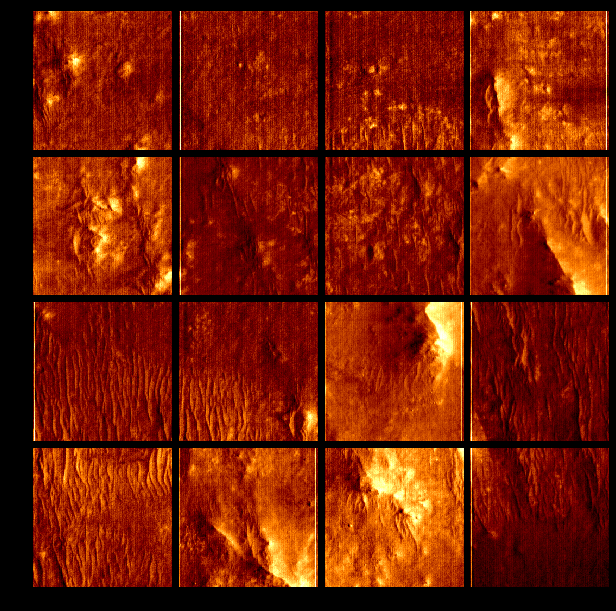

In [83]:
show_img_grid(anomalies_SVM_images[0:16])

### Isolation forest
https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest

In [22]:
clf_IF = IForest(max_samples=X_train.shape[0],
                      random_state=5, contamination=0.01)
clf_IF.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_IF_pred = clf_IF.labels_  # binary labels (0: inliers, 1: outliers)
y_IF_scores = clf_IF.decision_scores_  # raw outlier scores

D:\Anaconda\envs\mars-aae\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


In [23]:
#Create array of anomalies using results of isolation forest
anomalies_IF = np.array(np.where(y_IF_pred == 1))
anomalies_IF = anomalies_IF.reshape(anomalies_IF.shape[1])
anomalies_IF_images = [tensor_images[idx] for idx in anomalies_IF]

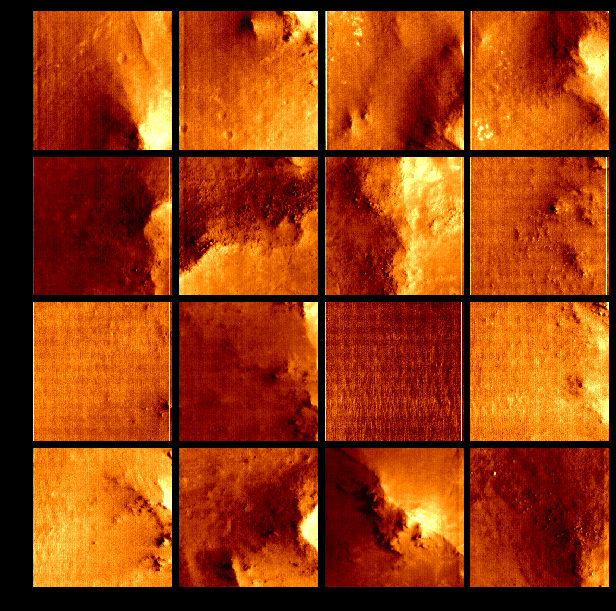

In [43]:
show_img_grid(anomalies_IF_images[0:16])

### Local outlier factor
https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.lof

In [24]:
#Using number of neighbors = 20 and contamination = 0.01
clf_LOF = LOF(n_neighbors = 20, contamination = 0.01)
clf_LOF.fit(X_train)

y_LOF_pred = clf_LOF.labels_  # binary labels (0: inliers, 1: outliers)
y_LOF_scores = clf_LOF.decision_scores_  # raw outlier scores

In [25]:
#Create array of anomalies using results of local outlier factor
anomalies_LOF = np.array(np.where(y_LOF_pred == 1))
anomalies_LOF = anomalies_LOF.reshape(anomalies_LOF.shape[1])
anomalies_LOF_images = [tensor_images[idx] for idx in anomalies_LOF]

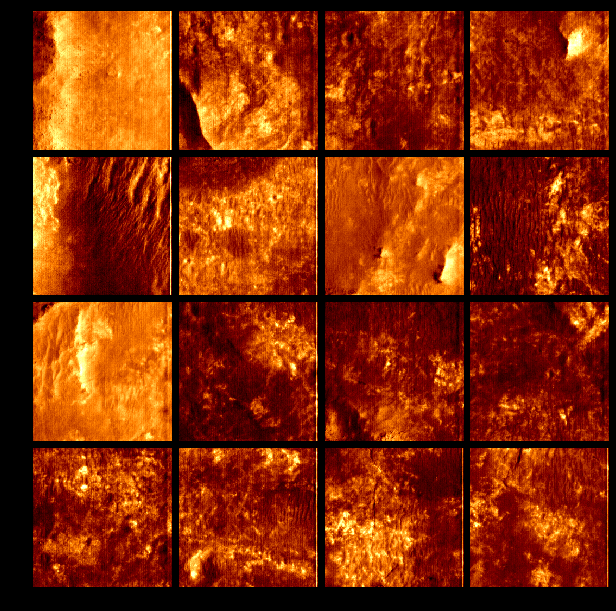

In [88]:
show_img_grid(anomalies_LOF_images[0:16])

## Outlier detection using results of 3 previous methods

Probabilities and scores allow us to combine many methods and make a better prediction. Scores will be used first. 

In [89]:
print('Isolation Forests Scores')
print('Mean: ' + str(y_IF_scores.mean()))
print('Std: ' + str(y_IF_scores.std()))
print('Min: ' + str(y_IF_scores.min()))
print('Max: ' + str(y_IF_scores.max()))

Isolation Forests Scores
Mean: -0.13225495931053088
Std: 0.033439219806325596
Min: -0.1738708438648055
Max: 0.15441813310695995


In [90]:
print('One Class SVM Scores')
print('Mean: ' + str(y_SVM_scores.mean()))
print('Std: ' + str(y_SVM_scores.std()))
print('Min: ' + str(y_SVM_scores.min()))
print('Max: ' + str(y_SVM_scores.max()))

One Class SVM Scores
Mean: -4.015565725446202e+17
Std: 4.7903024318218816e+17
Min: -2.0481130410875323e+18
Max: 7.400185774817286e+16


In [91]:
print('Local Outlier Factor Scores')
print('Mean: ' + str(y_LOF_scores.mean()))
print('Std: ' + str(y_LOF_scores.std()))
print('Min: ' + str(y_LOF_scores.min()))
print('Max: ' + str(y_LOF_scores.max()))

Local Outlier Factor Scores
Mean: 1.7966198381941012
Std: 0.7189407823814883
Min: 0.968857857376458
Max: 7.267416858841132


As we can see, our score distribution have very different means and standard deviations and to create threshold for combination of these methods we should normalize them first.

In [93]:
y_IF_scores_normalized = (y_IF_scores - y_IF_scores.mean())/y_IF_scores.std() 
y_SVM_scores_normalized = (y_SVM_scores - y_SVM_scores.mean())/y_SVM_scores.std()
y_LOF_scores_normalized = (y_LOF_scores - y_LOF_scores.mean())/y_LOF_scores.std()

In [94]:
print(y_IF_scores_normalized.mean())
print(y_SVM_scores_normalized.mean()) 
print(y_LOF_scores_normalized.mean())

-1.938725063465485e-16
1.1632350380792908e-16
-3.1019601015447757e-16


In [95]:
print(y_IF_scores_normalized.std())
print(y_SVM_scores_normalized.std()) 
print(y_LOF_scores_normalized.std())

1.0
1.0
1.0


In [96]:
print(y_IF_scores_normalized.min())
print(y_SVM_scores_normalized.min()) 
print(y_LOF_scores_normalized.min())

-1.2445231914891228
-3.4372703852785387
-1.1513632292157432


In [97]:
print(y_IF_scores_normalized.max())
print(y_SVM_scores_normalized.max()) 
print(y_LOF_scores_normalized.max())

8.572959957733875
0.9927524139888707
7.6095238366156375


Building histigrams can give us better understanding of our distributions.

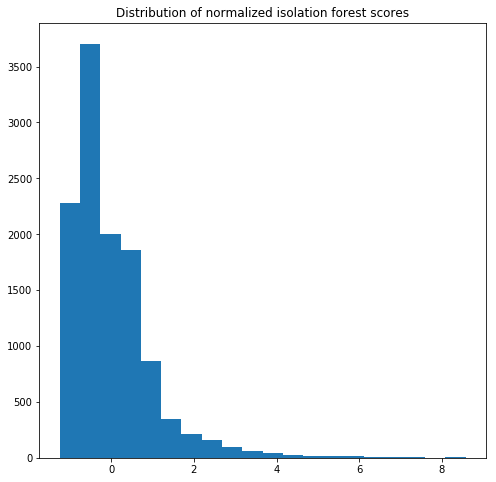

In [112]:
plt.figure(figsize=(8,8))
plt.hist(y_IF_scores_normalized, bins=20)
plt.title('Distribution of normalized isolation forest scores')
plt.show()

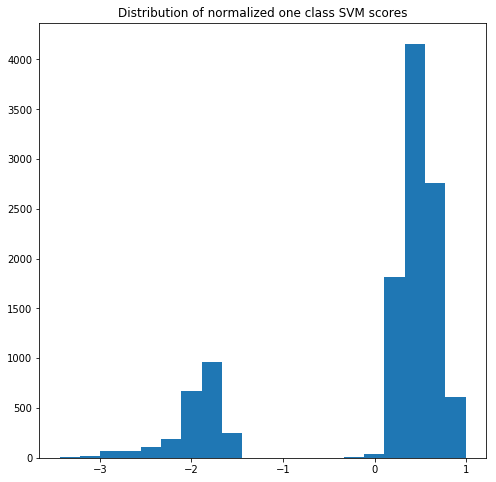

In [111]:
plt.figure(figsize=(8,8))
plt.hist(y_SVM_scores_normalized, bins=20)
plt.title('Distribution of normalized one class SVM scores')
plt.show()

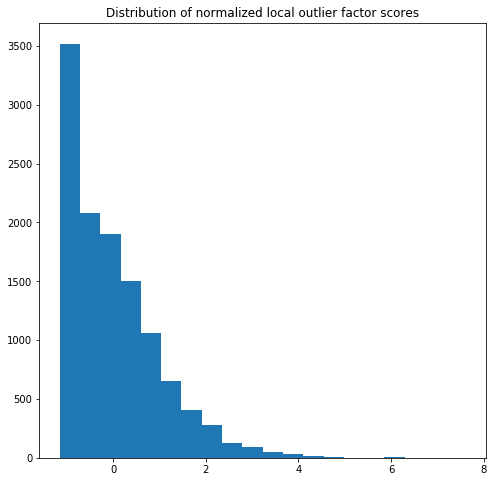

In [110]:
plt.figure(figsize=(8,8))
plt.hist(y_LOF_scores_normalized, bins=20)
plt.title('Distribution of normalized local outlier factor scores')
plt.show()

Now our distributions are normalized and have similar means and standard deviations, so we can work with their averages and maximums and they will have equal impact on the result. However, one class SVM score distribution looks different from LOF and IF score, so we won't use it now and will try to solve this problem later.

In [117]:
average_score = (y_LOF_scores_normalized + y_IF_scores_normalized)/2

In [135]:
anomalies_average = np.array(np.where(average_score>3))
anomalies_average = anomalies_average.reshape(anomalies_average.shape[1])
anomalies_average_images = [tensor_images[idx] for idx in anomalies_average]

In [136]:
anomalies_average

array([ 3129,  3950,  3954,  3980,  3984,  3993,  4364,  5466,  5467,
        6010,  6022,  6526,  7035,  7037,  7044,  7305,  7309,  7405,
        7508,  7568,  7649,  8267,  8271,  8325,  8511,  8514,  9410,
        9411,  9412,  9600,  9999, 10000, 10001, 10002, 10189, 10194,
       10574, 10575, 10576, 10577, 10578, 10753, 10755, 10756, 10758,
       11152, 11153, 11154, 11155, 11156, 11158, 11317, 11318, 11319,
       11320], dtype=int64)

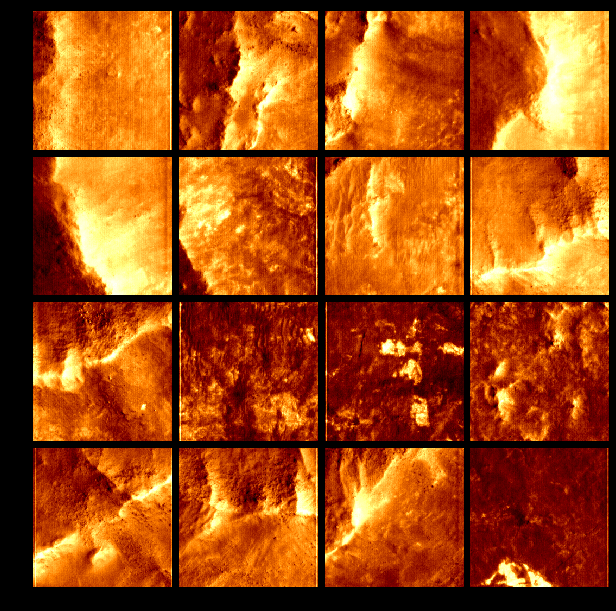

In [138]:
show_img_grid(anomalies_average_images[0:16])

In [29]:
#We can get information about location of this anomaly in our data
ids[anomalies_LOF[17]]

'ESP_011261_1960_RED4_0.IMG_17_0'

# Result
This is the first version of outlier detection. I used PyOD for this purpose. 3 models were used for this task and their hyper parameters are not ideal right now.